<a href="https://colab.research.google.com/github/aCStandke/GAN_Models/blob/main/DCGAN_on_Face.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [95]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
import os
import random
import time
from IPython.display import HTML
from IPython import display
from keras.datasets import fashion_mnist
from keras.layers import Conv2D, Conv2DTranspose, BatchNormalization, Dropout, Input, Dense, Reshape, Flatten
from keras.layers import LeakyReLU
from keras.models import Sequential, Model
from keras.optimizers import adam_v2
import keras
import tensorflow as tf

In [ ]:
# !mv /content/drive/MyDrive/Kaggle/kaggle.json /root/.kaggle/
# !kaggle datasets download zuozhaorui/celeba
# !unzip celeba.zip

In [5]:
dataroot = "/content/img_align_celeba/"
train_ds = tf.keras.utils.image_dataset_from_directory(dataroot, shuffle=True, batch_size=128, image_size=(64, 64))
normalization_layer = tf.keras.layers.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))

Found 202599 files belonging to 1 classes.


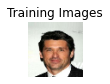

In [23]:
# Plot some training images
real_batch = next(iter(normalized_ds))
sample = real_batch[0]
sample_array = sample[0][:][:][:]
plt.figure(figsize=(1,1))
plt.axis("off")
plt.title("Training Images")
plt.imshow(sample_array)

# Globals relating to latent dimension, weight initialization and channels

In [38]:
# latent dimension of the random noise
latent_dim = 100
# weight initializer for generator per DCGAN paper
WEIGHT_INIT = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)
# number of channels, 1 for gray scale and 3 for color images
CHANNELS = 3
BATCH_SIZE = 128
image_size = 64

# Generator


In [84]:
# function that builds the generator
def build_generator(latent_input, weight_initialization, channel):
  model = Sequential(name='generator')  
  model.add(keras.layers.Dense(8*8*512, input_shape=(latent_input,)))
  model.add(keras.layers.BatchNormalization())
  model.add(keras.layers.ReLU()) 
  model.add(keras.layers.Reshape((8, 8, 512)))
  model.add(keras.layers.Conv2DTranspose(filters=256, kernel_size=(4,4), strides=(1,1), padding='same', kernel_initializer=weight_initialization, use_bias=False)) 
  model.add(keras.layers.BatchNormalization())
  model.add(keras.layers.ReLU()) 
  model.add(keras.layers.Conv2DTranspose(filters=128, kernel_size=(4,4), strides=(2,2), padding='same', kernel_initializer=weight_initialization, use_bias=False)) 
  model.add(keras.layers.BatchNormalization())
  model.add(keras.layers.ReLU())
  model.add(keras.layers.Conv2DTranspose(filters=64, kernel_size=(4,4), strides=(2,2), padding='same', kernel_initializer=weight_initialization, use_bias=False)) 
  model.add(keras.layers.BatchNormalization())
  model.add(keras.layers.ReLU())
  model.add(keras.layers.Conv2DTranspose(filters=channel, kernel_size=(4,4), strides=(2,2),padding='same', activation='tanh'))
  return model

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


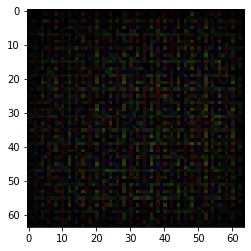

In [86]:
generator = build_generator(latent_dim, WEIGHT_INIT, CHANNELS)
noise = tf.random.normal([ 1, 100], 0, 15)
generated_image = generator(noise, training=False)
generated_image.shape
plt.imshow(generated_image[0,:,:,:3])

# Discriminator

In [88]:
def build_discriminator(width, height, depth, alpha=0.2):
  model = Sequential(name='discriminator')
  input_shape = (height, width, depth)
  model.add(keras.layers.Conv2D(filters=64, kernel_size=(4, 4), strides=(2,2), padding='same', input_shape = input_shape, use_bias=False))
  model.add(keras.layers.BatchNormalization())
  model.add(keras.layers.LeakyReLU(alpha=alpha))
  model.add(keras.layers.Conv2D(filters=128, kernel_size=(4, 4), strides=(2,2),padding='same', use_bias=False))
  model.add(keras.layers.BatchNormalization())
  model.add(keras.layers.LeakyReLU(alpha=alpha))
  model.add(keras.layers.Conv2D(filters=256, kernel_size=(4, 4), strides=(2,2),padding='same', use_bias=False))
  model.add(keras.layers.BatchNormalization())
  model.add(keras.layers.LeakyReLU(alpha=alpha))
  model.add(keras.layers.Conv2D(filters=512, kernel_size=(4, 4), strides=(2,2),padding='same', use_bias=False))
  model.add(keras.layers.BatchNormalization())
  model.add(keras.layers.LeakyReLU(alpha=alpha))
  model.add(keras.layers.Flatten()) 
  model.add(keras.layers.Dropout(0.3))
  model.add(keras.layers.Dense(1, activation='sigmoid')) 
  return model                
  

In [89]:
discriminator = build_discriminator(64, 64, 3)
decision = discriminator(generated_image)
print(decision)

tf.Tensor([[0.49833545]], shape=(1, 1), dtype=float32)


# Binary Cross Entropy

In [27]:
# use this method to compute the binary crossentopy loss
binary_crossEntropy = keras.losses.BinaryCrossentropy()

# Discriminator Loss

In [28]:
def discriminator_loss(real_output, fake_output):
  # discriminator loss on real images
  real_loss = binary_crossEntropy(tf.ones_like(real_output), real_output)
  # discriminator loss on fake images
  fake_loss = binary_crossEntropy(tf.zeros_like(fake_output), fake_output)
  # discriminator total loss
  total_loss = real_loss + fake_loss
  return total_loss

# Generator Loss

In [29]:
def generator_loss(fake_output):
  return binary_crossEntropy(tf.ones_like(fake_output), fake_output)

# Different Optimizers for Generator and Discriminator

In [30]:
generator_optimizer = keras.optimizers.adam_v2.Adam(learning_rate=0.0002, beta_1=0.5, beta_2=0.999)
discriminator_optimizer = keras.optimizers.adam_v2.Adam(learning_rate=0.0002, beta_1=0.5, beta_2=0.999)

# Train Function

In [96]:
EPOCS = 5
noise_dim = 100
num_examples_to_generate = 16

# seed value 
seed = tf.random.normal([num_examples_to_generate, noise_dim])


In [93]:
# annotation creates and compiles a tensorflow graph from the function

def train_step(images):
  noise = tf.random.normal([BATCH_SIZE, noise_dim])

  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_images = generator(noise, training=True)

    real_output = discriminator(images, training=True)
    fake_output = discriminator(generated_images, training=True)
    
    gen_loss = generator_loss(fake_output)
    disc_loss = discriminator_loss(real_output, fake_output)
  
  # generate the gradients for the geneartor and discriminator with respect to the weights
  gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
  gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

  # backpropogate the gradients and perform gradient descent using Adam on the weights
  generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))


In [98]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch, _ in dataset:
      train_step(image_batch)
    
    # Produce images for the GIF as you go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)
    print('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

# Plot Generated Images

In [100]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, :3])
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

# Train Model

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

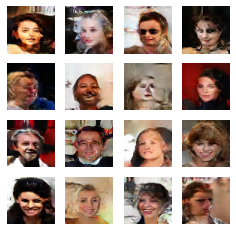

In [101]:
train(normalized_ds, EPOCS)